---
## 概要


機械学習を利用して、異常検知や病気の罹患を代表とする2値分類を行う際は、ラベル有りのデータに対して学習と予測を行う。しかし、実世界で汎用的に機械学習を応用する時には、ラベル付与のコストから、ラベル有りデータが手に入らない場合が数多く存在する。今回はその中で、**一部のみにラベルが付与されている状況、特にPositive（異常）データに対してラベルが付与されているケース**を考える。この場合に、効率的な学習法として**`PULearning（Positive and Unlabeled Learning）`**という手法が提案されている。

PULearningとは二値分類のための機械学習手法で、学習データとしてPositiveデータにラベル付けされたデータと、PositiveとNegativeに分類されるデータがラベル付けされていない状態で未知の割合で構成するテストデータを使用して分類を行う。つまり、つまり、Negativeに分類されるデータは全てラベル付けされていないデータを使用する。PULearningは、ラベル付けされていない例を単に負の例として扱う場合や、ラベル付けされていないデータを無視しし、ラベル有りのPositiveのサンプルのみを対象とした1クラス分類を学習する場合と比較して、Positiveクラスのみで構成されるデータを考慮した、効率的な分類を可能にする手法として提案された。

## PULearning

### 理論
PULearningの理論は本質的に, Positiveのデータとラベル付けされていないデータが含まれるデータセットが与えられた場合, あるサンプルがPositiveである確率 $[ P(y=1|x)]$ は, そのサンプルがラベル付けされている確率 $[P(s=1|x)]$ を, 正のサンプルがラベル付けされている確率 $[ P(s=1|y=1)]$ で割ったものに等しいする. サンプルがPositiveかNegativeかを判断するモデルを訓練するのに, 十分なラベル有りデータが無い状況においてでさえ, Positiveのサンプルがラベル付けされる（つまりPositiveと判断する）可能性が高いという基準でPositiveかどうかを推定するのは可能であると筆者（提案者）は述べている. 

- $x$ : サンプルデータ
- $y=1$ : Positive,陽性 （真値）
- $y=0$ : Negative, 陰性 （真値）
- $s=1$ : ラベル有り（Positive, 陽性）（初期データに関しては真値）
- $s=0$ : ラベル無し（Negative, 陰性）


つまり, Positiveとラベル付けされたサンプルのグループだけを持つ, ラベル無しデータセットが与えられた場合, $P(s=1|x) / P(s=1|y=1)$を推定すれば, ラベル付けされていないサンプル$x$がPositiveである確率を推定することができるということ. 

### PULearningの手順
1. ラベルの有無を判断するモデルを目的変数 $y$ として使用しながら, ラベル付きデータとラベル無しデータを含むデータセットを分類モデルに学習させる. そのモデルは, 与えられたデータ $x$ がラベル付きである確率 $P(s=1| x)$ を予測するように訓練される. 

2. 分類モデルを使用して, データセット内の既知のPositiveデータがラベル付けされる確率を予測し, 予測結果がPositiveデータがラベル付けされる確率 $P(s=1|y=1|x)$ を表すようにする. そうして予測された確率の平均を計算すると $P(s=1|y=1)$ になる. 

3. $P(s=1|y=1)$を推定したため, ここでデータ $k \in x$がPosotoveである確率を予測する, つまり手順1で学習したモデルを使用してラベル付けされている確率$P(s=1|k)$を推定する. 

4. P(s=1|k)を推定したら, 手順2で推定したP(s=1|y=1)で割ることで実際にkを分類し, それがどちらのクラスに属するかの実際の確率を得る. 

### 参考文献
- [Semi-Supervised Classification of Unlabeled Data (PU Learning)](https://towardsdatascience.com/semi-supervised-classification-of-unlabeled-data-pu-learning-81f96e96f7cb)

## 実験1  Breast cancer data
PU Learningを **breast cancer data**に適応する。  
Data : https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
#### 参考資料
- [pulearn](https://pulearn.github.io/pulearn/)
- [pulearn examples](https://pypi.org/project/pulearn/#examples)

### ライブラリ

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from pulearn import ElkanotoPuClassifier,WeightedElkanotoPuClassifier

### データの読み込みと整形

In [26]:
def load_breast_cancer(path):
    """Load breast cancer data from path."""
    with open(path) as f:
        lines = f.readlines()
    examples = []
    labels = []
    for line in lines:
        spt = line.split(',')
        label = float(spt[-1])
        feat = spt[:-1]
        if '?' not in spt:
            examples.append(feat)
            labels.append(label)
    return np.array(examples), np.array(labels)

np.random.seed(42)

fpath = 'datasets/breast-cancer-wisconsin.data'
X, y = load_breast_cancer(fpath)

permut = np.random.permutation(len(y))
X = X[permut]
y = y[permut]
y[np.where(y == 2)[0]] = -1. # 良性
y[np.where(y == 4)[0]] = +1. # 悪性

print("Loaded {} examples.".format(len(y)))
print("{} 良性.".format(len(np.where(y == -1.)[0])))
print("{} 悪性.".format(len(np.where(y == +1.)[0])))

print("\n学習データとテストデータに分割")
split = int(2*len(y)/3)
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]
print("学習データ数 = {}.".format(len(y_train)))
print("良性の数 = {}.".format(len(np.where(y_train == -1.)[0])))
print("悪性の数 = {}.".format(len(np.where(y_train == +1.)[0])))

Loaded 683 examples.
444 良性.
239 悪性.

学習データとテストデータに分割
学習データ数 = 455.
良性の数 = 296.
悪性の数 = 159.


### PU Learning 分類
**ラベル無しデータを徐々に増やしていき、PU Learningの有効性を確認する**

In [42]:
pu_f1_scores = []  # PU Learningを使用した際の結果
reg_f1_scores = [] # PU Learningを使用しない場合の結果
hold_out_limit = 21 # 内部で実行される hold outで最低限必要なデータ数
n_sacrifice_iter = range(0, len(np.where(y_train == +1.)[0])-hold_out_limit, 10) # ラベル無しデータの数

for n_sacrifice in n_sacrifice_iter:
    
    y_train_pu = np.copy(y_train)
    pos = np.where(y_train == +1.)[0] # 悪性（Positive）データのindex
    np.random.shuffle(pos)
    
    # 悪性データの n_sacrifice分を良性とする（つまり、ラベルが振られていない状態にする）
    sacrifice = pos[:n_sacrifice] 
    y_train_pu[sacrifice] = -1.
    pos = len(np.where(y_train_pu == -1.)[0])
    unlabelled = len(np.where(y_train_pu == +1.)[0])
    
    print("ラベル有りPositiveデータの数 = {}".format(len(np.where(y_train_pu == +1.)[0])))
    
    '''''''''''''''''''''
        PU Learning
    '''''''''''''''''''''
    estimator = RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        bootstrap=True,
        n_jobs=1,
    )
    pu_estimator = ElkanotoPuClassifier(estimator)
    # pu_estimator = WeightedElkanotoPuClassifier(estimator, pos, unlabelled)
    
    pu_estimator.fit(X_train, y_train_pu)
    y_pred = pu_estimator.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
    pu_f1_scores.append(f1_score[1])
    
    print("===== PU Learning applied =====")
    print("F1 score: {}".format(f1_score[1]))
    print("Precision: {}".format(precision[1]))
    print("Recall: {}".format(recall[1]))
    
    
    '''''''''''''''''''''
      Regular Learning
    '''''''''''''''''''''
    estimator = RandomForestClassifier(
        n_estimators=100,
        bootstrap=True,
        n_jobs=1,
    )
    estimator.fit(X_train, y_train_pu)
    y_pred = estimator.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)
    reg_f1_scores.append(f1_score[1])
    print("===== PU Learning not applied =====")
    print("F1 score: {}".format(f1_score[1]))
    print("Precision: {}".format(precision[1]))
    print("Recall: {}".format(recall[1]))
    print()

ラベル有りPositiveデータの数 = 159
ラベル有りPositiveデータの数 = 455
===== PU Learning applied =====
F1 score: 0.9565217391304348
Precision: 0.9506172839506173
Recall: 0.9625
===== PU Learning not applied =====
F1 score: 0.9565217391304348
Precision: 0.9506172839506173
Recall: 0.9625

ラベル有りPositiveデータの数 = 149
ラベル有りPositiveデータの数 = 455
===== PU Learning applied =====
F1 score: 0.9565217391304348
Precision: 0.9506172839506173
Recall: 0.9625
===== PU Learning not applied =====
F1 score: 0.9367088607594937
Precision: 0.9487179487179487
Recall: 0.925

ラベル有りPositiveデータの数 = 139
ラベル有りPositiveデータの数 = 455
===== PU Learning applied =====
F1 score: 0.9625000000000001
Precision: 0.9625
Recall: 0.9625
===== PU Learning not applied =====
F1 score: 0.9559748427672956
Precision: 0.9620253164556962
Recall: 0.95

ラベル有りPositiveデータの数 = 129
ラベル有りPositiveデータの数 = 455
===== PU Learning applied =====
F1 score: 0.9565217391304348
Precision: 0.9506172839506173
Recall: 0.9625
===== PU Learning not applied =====
F1 score: 0.9500000000

### 結果の描画

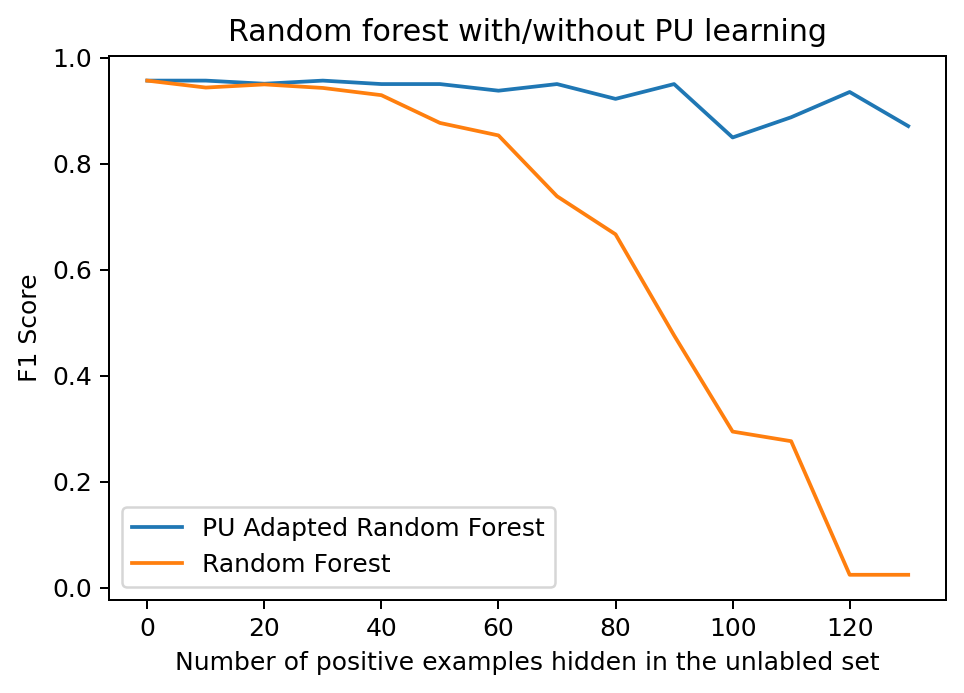

In [36]:
plt.figure(dpi=180)
plt.title("Random forest with/without PU learning")
plt.plot(n_sacrifice_iter, pu_f1_scores, label='PU Adapted Random Forest')
plt.plot(n_sacrifice_iter, reg_f1_scores, label='Random Forest')
plt.xlabel('Number of positive examples hidden in the unlabled set')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

## 実験2 Artificial data

PU Learningを **人工的に作成するデータ**に適応する。  

#### 参考資料
- [pulearn ElkanotoPuClassifierExample](https://github.com/pulearn/pulearn/blob/master/examples/ElkanotoPuClassifierExample.py)
- [PU learning techniques applied to artificial data](https://github.com/pulearn/pulearn/blob/master/notebooks/bagging_blobs.ipynb)

### 人工データの作成

In [117]:
import pandas as pd                    # for data handling
import numpy as np                     # for random selections, mainly
import matplotlib.pyplot as plt        # for plotting
%matplotlib inline                  

In [118]:
# データを作成
from sklearn.datasets import make_blobs
X, y = make_blobs(
    n_samples = 6000, 
    centers = [[1,5], [5,1], [0,0], [6,6]]
)
y = (y > 1).astype(int)  # [0,1]ラベルに変換
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y)

print(f'データ数 = {X.shape[0]}, 特徴量 = {X.shape[1]}')
print(f'全データ = {len(y)}, Positiveデータ = {sum(y)}')

データ数 = 6000, 特徴量 = 2
全データ = 6000, Positiveデータ = 3000


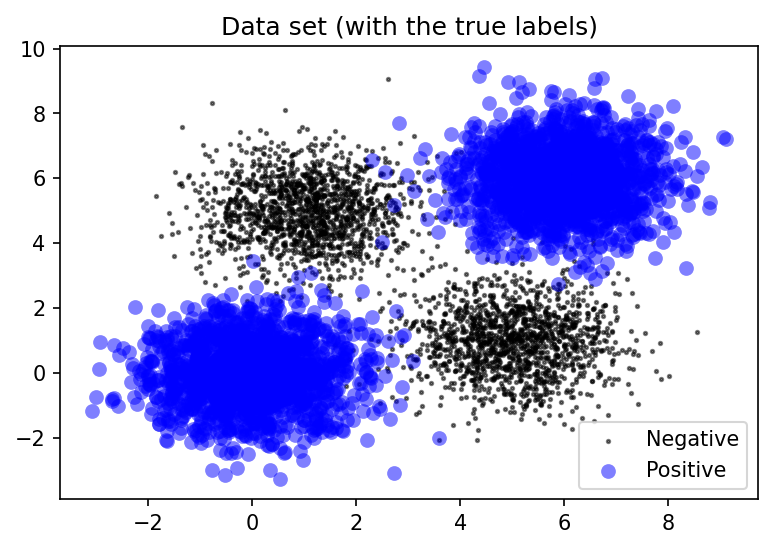

In [119]:
# 正解データの描画
plt.figure(dpi=150)
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Negative'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (with the true labels)')
plt.show()

In [120]:
# 正解ラベルを確保
y_orig = y.copy()

# ラベル無しデータの作成
hidden_size = 2700 # ラベル無しデータ数 （FYI 全データは6000）
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

print(f'全データ = {len(y)}, Positiveデータ = {sum(y)}')

全データ = 6000, Positiveデータ = 300


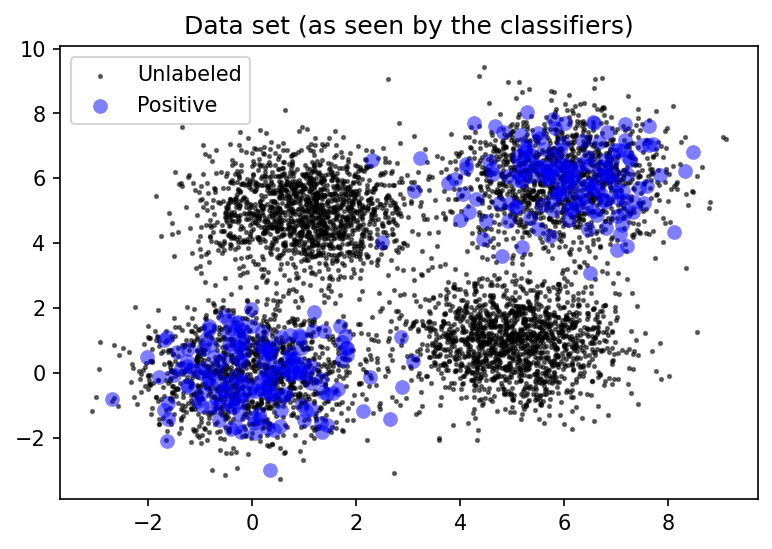

In [121]:
# ラベル有りPositiveデータを制限した状況でのデータの描画
plt.figure(dpi=150)
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

### PU Learningを使用しない場合の分類

In [122]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  
    n_jobs = 1           
)
rf.fit(X, y)

results = pd.DataFrame({
    'truth'      : y_orig,   # 正解ラベル
    'label'      : y,        # ラベル無しデータを増やしたときのラベル
    'output_std' : rf.predict_proba(X)[:,1]   # モデルの予測結果
}, columns = ['truth', 'label', 'output_std'])

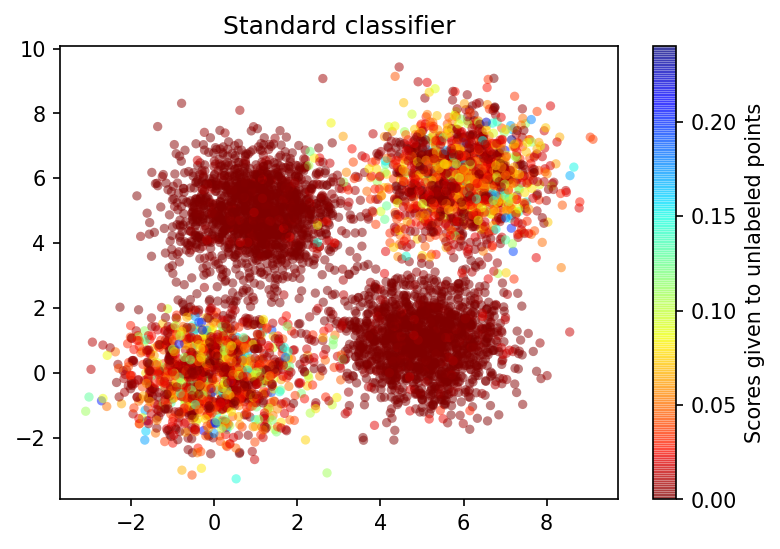

In [123]:
# 結果の描画（RandomForestの予測確率をヒートマップで描画）
plt.figure(dpi=150)
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_std, linewidth = 0, s = 20, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

### PU Learningを使用する場合の分類

In [124]:
from pulearn import BaggingPuClassifier
from sklearn.tree import DecisionTreeClassifier

# バギング系のPULearningを使用するので決定木を増やしてRFのようにする
bc = BaggingPuClassifier(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  
    max_samples = sum(y), 
    n_jobs = -1           
)
bc.fit(X, y)
results['output_bag'] = bc.oob_decision_function_[:,1]

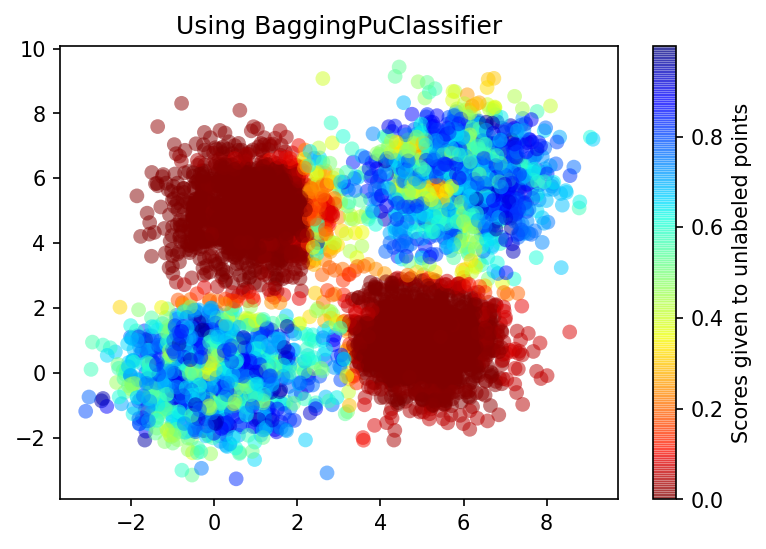

In [125]:
# 結果の描画（RandomForestの予測確率をヒートマップで描画）
plt.figure(dpi=150)
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bag, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using BaggingPuClassifier')
plt.show()

### 結果の比較

In [126]:
# PULearning無しの場合とPULearning有りの場合のそれぞれにおいて、
# 最もPositiveと予想した確率が高いものを予想結果から t個 選択し、
# その正解データの平均を求める。
ts = range(100, hidden_size+1, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_bag.append(
        results[results.label == 0].sort_values(
            'output_bag', ascending = False
        ).head(t).truth.mean()
    )

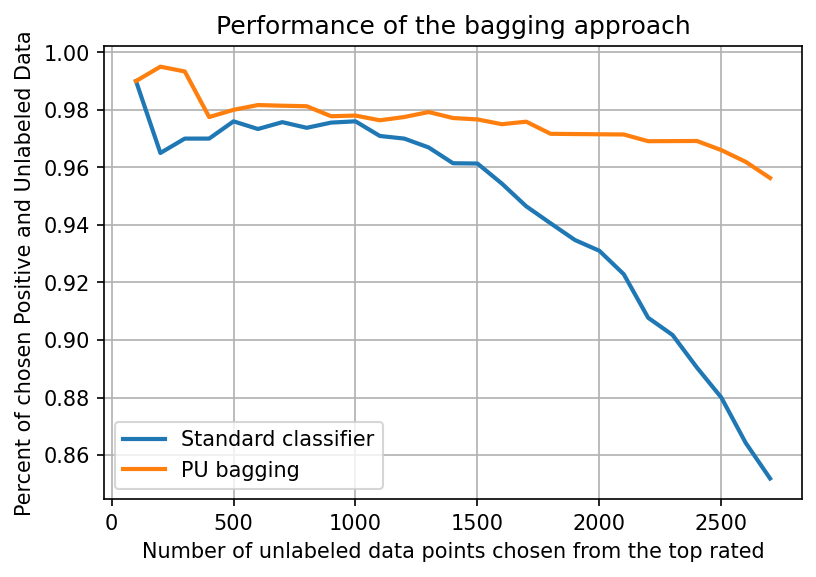

In [135]:
# 上で計算したデータを描画する
'''
    横軸 : Positiveと予想した確率が高い順から t個 選択するときのtの値
    縦軸 : 選択されたデータの正解ラベルの平均
          (例) 100% → t個をPositiveと正しく判断した中で、t個が正しくPositiveであった
            　  50% → t個をPositiveと正しく判断した中で、t/2個が正しくPositiveであった
'''

plt.figure(dpi=150)
plt.plot(
    ts, y_std,
    ts, y_bag,
    lw = 2
)
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen Positive and Unlabeled Data')
plt.legend([
    'Standard classifier', 
    'PU bagging', 
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the bagging approach')
plt.grid()
plt.show()